This notebook aims to analyze the training results of JAX-CanVeg.

In [1]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline 

In [2]:
# Plotting parameters
# rc('text', usetex=False)
small_size = 15
medium_size = 25
bigger_size = 30
plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)    # fontsize of the axes title
plt.rc('axes', labelsize=small_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=small_size)  # fontsize of the figure title
plt.rc('text', usetex = False)

# Locations of files and folders

In [34]:
sites = ["US-Bi1", "US-Me2", "US-Whs", "US-Hn1"]
canopy_layers = ["1L", "ML"]
model_types = ["PB", "Hybrid"]
le_weight = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
canveg_combinations = list(
    itertools.product(sites, canopy_layers, model_types, le_weight)
)
dnn_combinations = list(itertools.product(sites, le_weight))

metrics = ["mse", "nse", "cc"]
outputs = ["LE", "NEE"]

# Load the training results

## Modeling performances

In [5]:
df_metrics = pd.DataFrame(
    columns=[
        "site",
        "model",
        "layer",
        "weight",
        "varn",
        "train_or_test",
        "rse",
        "mare",
        "rmse",
        "mse",
        "r2",
        "kge",
        "nse",
        "mkge",
        "cc",
        "alpha",
        "beta",
    ]
)
i = 0

# JAX-CanVeg
for site, cl, mt, mow in tqdm(canveg_combinations):
    dir_model = Path(site) / f"{mt}-{cl}-{mow}"
    f_metrics = dir_model / "metrics.csv"
    if not dir_model.is_dir() or not f_metrics.is_file():
        continue
    df_metrics_model = pd.read_csv(f_metrics, index_col=0)
    for index, row in df_metrics_model.iterrows():
        index = index.split("-")
        varn, train_or_test = index[0], index[1]
        df_metrics.loc[i] = [
            site,
            mt,
            cl,
            mow,
            varn,
            train_or_test,
            row["rse"],
            row["mare"],
            row["rmse"],
            row["mse"],
            row["r2"],
            row["kge"],
            row["nse"],
            row["mkge"],
            row["cc"],
            row["alpha"],
            row["beta"],
        ]
        i += 1

# DNN
for site, mow in tqdm(dnn_combinations):
    dir_model = Path(site) / f"DNN_LE-GPP-{mow}"
    f_metrics = dir_model / "metrics.csv"
    if not dir_model.is_dir() or not f_metrics.is_file():
        continue
    df_metrics_model = pd.read_csv(f_metrics, index_col=0)
    for index, row in df_metrics_model.iterrows():
        index = index.split("-")
        varn, train_or_test = index[0], index[1]
        df_metrics.loc[i] = [
            site,
            "DNN",
            "DNN",
            mow,
            varn,
            train_or_test,
            row["rse"],
            row["mare"],
            row["rmse"],
            row["mse"],
            row["r2"],
            row["kge"],
            row["nse"],
            row["mkge"],
            row["cc"],
            row["alpha"],
            row["beta"],
        ]
        i += 1

df_metrics.head()

100%|██████████| 44/44 [00:00<00:00, 47.37it/s]


,site,model,layer,weight,varn,train_or_test,rse,mare,rmse,mse,r2,kge,nse,mkge,cc,alpha,beta
0,US-Bi1,PB,1L,0.0,LE,train,0.848147,0.603508,97.420125,9490.680682,0.680070,0.187907,0.151853,0.478763,0.895474,1.503918,1.082640
1,US-Bi1,PB,1L,0.0,LE,test,0.406368,0.485929,68.835905,4738.381824,0.780133,0.488367,0.593632,0.635940,0.917216,1.354504,1.003690
2,US-Bi1,PB,1L,0.0,NEE,train,0.187391,-3.535173,4.375195,19.142330,0.764938,0.795620,0.812609,0.720097,0.901564,1.143536,0.780789
3,US-Bi1,PB,1L,0.0,NEE,test,0.238678,1812.275755,4.741722,22.483931,0.547656,-448.342740,0.761322,-448.343766,0.891314,450.342644,0.001613
4,US-Bi1,PB,1L,0.0,H,train,3.256006,7.475249,107.547240,11566.408921,0.400951,-0.397140,-2.256006,-1.278735,0.682310,0.719778,3.239014


## Simulations

In [6]:
df_simulations_set = {}

for site in sites:
    dir_model = Path(f"{site}/")
    case_set, df_train_set, df_test_set = [], [], []
    # JAX-CanVeg
    for cl, mt, mow in tqdm(itertools.product(canopy_layers, model_types, le_weight)):
        case_e = f"{mt}-{cl}-{mow}"
        dir_case = dir_model / case_e
        f_train = dir_case / "predictions_train.csv"
        f_test = dir_case / "predictions_test.csv"
        if not dir_case.is_dir() or not f_train.is_file() or not f_test.is_file():
            continue
        case_set.append(case_e)
        # Train
        df_train = pd.read_csv(f_train, index_col=0, parse_dates=True)
        df_train_set.append(df_train)

        # Test
        df_test = pd.read_csv(f_test, index_col=0, parse_dates=True)
        df_test_set.append(df_test)

    # DNN
    for w in le_weight:
        case_e = f"DNN_LE-GPP-{w}"
        dir_case = dir_model / case_e
        f_train = dir_case / "predictions_train.txt"
        f_test = dir_case / "predictions_test.txt"
        if not dir_case.is_dir() or not f_train.is_file() or not f_test.is_file():
            continue
        case_set.append(case_e)
        # Train
        df_train = pd.DataFrame(np.loadtxt(f_train), columns=["LE", "NEE"])
        df_train.index = df_train_set[-1].index
        df_train_set.append(df_train)

        # Test
        df_test = pd.DataFrame(np.loadtxt(f_test), columns=["LE", "NEE"])
        df_test.index = df_test_set[-1].index
        df_test_set.append(df_test)

    df_train_big = pd.concat(df_train_set, axis=1, keys=case_set)
    df_test_big = pd.concat(df_test_set, axis=1, keys=case_set)

    df_simulations_set[f"{site}-train"] = df_train_big
    df_simulations_set[f"{site}-test"] = df_test_big

44it [00:10,  4.37it/s]
44it [00:07,  5.59it/s]
44it [00:09,  4.82it/s]
44it [00:06,  7.28it/s]


In [7]:
# df_simulations_set["US-Bi1-train"]

# Computational cost assessment

In [8]:
usbi1_time = {
    'Matlab': 1144.13, 
    'JAX-CPU': 46.12,
    'JAX-GPU': 2.27 
}

ushn1_time = {
    'Matlab': 751.67, 
    'JAX-CPU': 23.19,
    'JAX-GPU': 1.93 
}

usme2_time = {
    'Matlab': 2846.56, 
    'JAX-CPU': 70.70,
    'JAX-GPU': 2.83
}

uswhs_time = {
    'Matlab': 1474.65, 
    'JAX-CPU': 57.40,
    'JAX-GPU': 2.52
}

# Convert it to pandas dataframe
compute_time = pd.DataFrame(
    [usbi1_time, ushn1_time, usme2_time, uswhs_time]
)
compute_time.index = ['US-Bi1', 'US-Hn1', 'US-Me2', 'US-Whs']
compute_time_df = pd.melt(compute_time.reset_index(), id_vars='index',value_vars=['Matlab','JAX-CPU', 'JAX-GPU'])
compute_time_df.rename(columns={"index": "Site", "variable": "Model", "value":"Time"}, inplace=True)


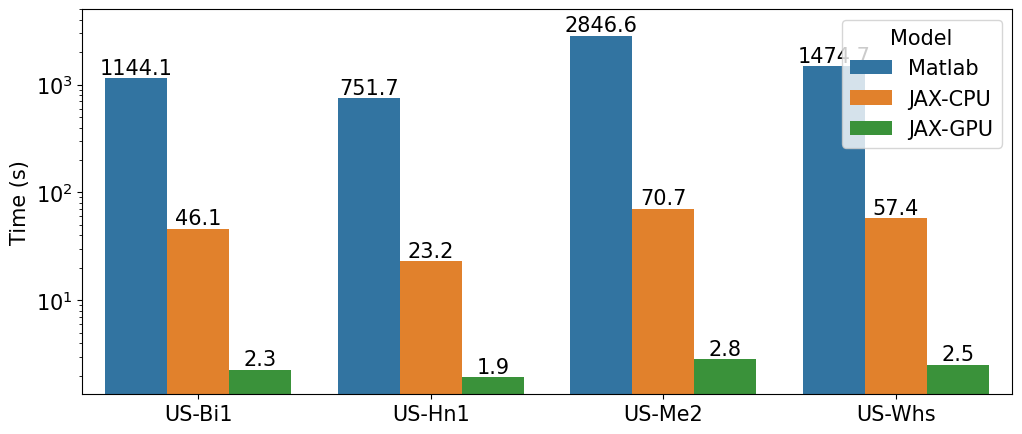

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
sns.barplot(compute_time_df, x="Site", y="Time", hue="Model", ax=ax)
ax.set(yscale='log', ylabel='Time (s)', xlabel='', ylim=[None, 5000]);
for i in ax.containers:
    ax.bar_label(i,fmt='%.1f')
    

# Hybrid modeling vs process-based modeling

In [9]:
def filter_metric(
    df_metrics,
    site=None,
    model=None,
    layer=None,
    weight=None,
    varn=None,
    train_or_test=None,
):
    conditions = []
    if site is not None:
        conditions.append(df_metrics["site"] == site)
    if model is not None:
        model = [model] if isinstance(model, str) else model
        conditions.append(df_metrics["model"].isin(model))
    if layer is not None:
        layer = [layer] if isinstance(layer, str) else layer
        conditions.append(df_metrics["layer"].isin(layer))
    if weight is not None:
        # conditions.append(df_metrics["weight"] == weight)
        weight = [weight] if isinstance(weight, str) else weight
        conditions.append(df_metrics["weight"].isin(weight))
    if varn is not None:
        conditions.append(df_metrics["varn"] == varn)
    if train_or_test is not None:
        conditions.append(df_metrics["train_or_test"] == train_or_test)
    and_condition = conditions[0]
    for condition in conditions:
        and_condition &= condition
    return df_metrics[and_condition]

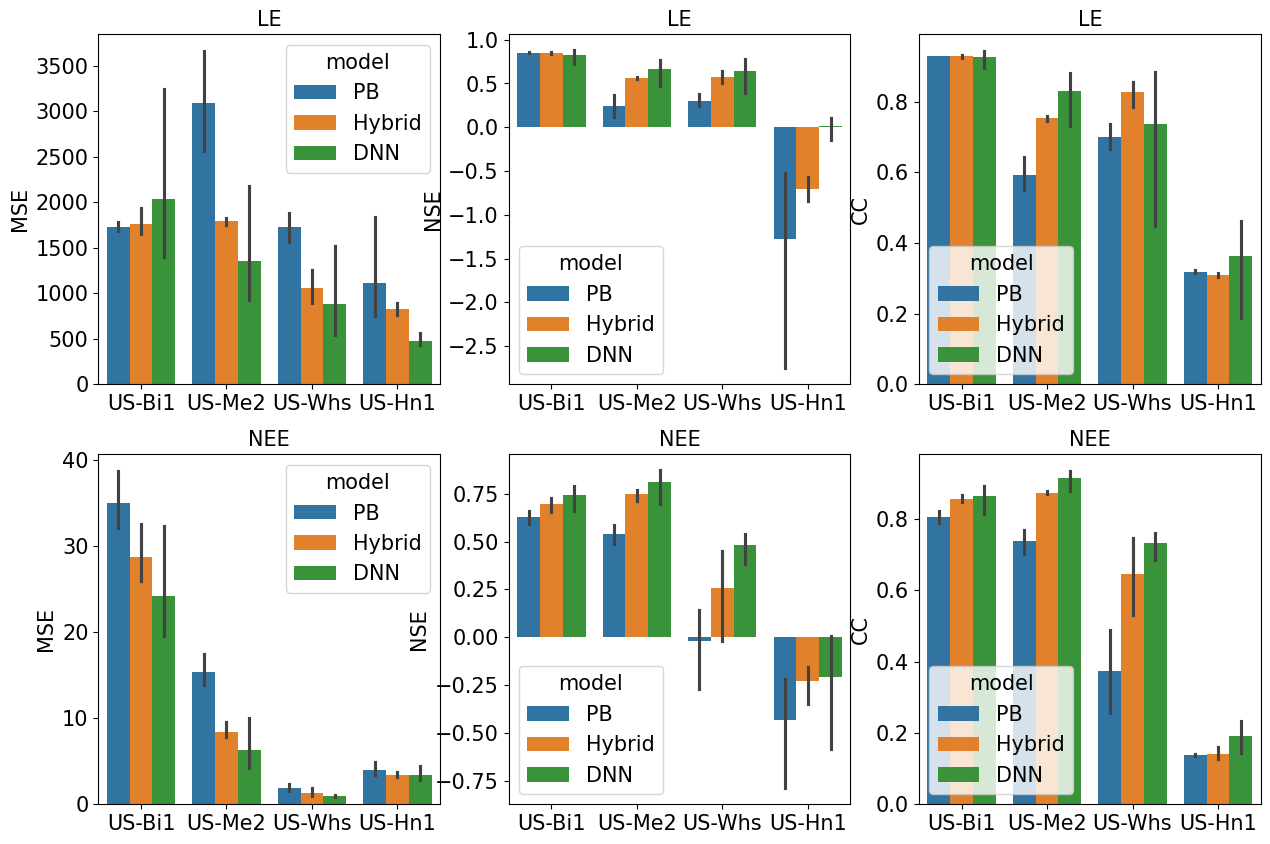

In [35]:
train_or_test, layer = "test", ["ML", "DNN"]
fig, axes = plt.subplots(2, len(metrics), figsize=(15, 10))
for i, varn in enumerate(["LE", "NEE"]):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        df_metrics_sub = filter_metric(
            df_metrics, layer=layer, varn=varn, train_or_test=train_or_test
        )
        sns.barplot(df_metrics_sub, ax=ax, x="site", y=metric, hue="model", legend=True)
        ax.set(xlabel="", ylabel=metric.upper(), title=varn,
               yscale="symlog" if (varn=="NEE") and (metric=="mkge") else "linear")


# Multilayer canopy model vs single layer canopy model

In [21]:
# train_or_test, model = "test", ["PB", "DNN"]
# fig, axes = plt.subplots(len(outputs), len(metrics), figsize=(15, 8))
# for i, varn in enumerate(outputs):
#     for j, metric in enumerate(metrics):
#         ax = axes[i, j]
#         df_metrics_sub = filter_metric(
#             df_metrics, model=model, varn=varn, train_or_test=train_or_test
#         )
#         sns.barplot(df_metrics_sub, ax=ax, x="site", y=metric, hue="layer", legend=True)
#         ax.set(xlabel="", ylabel=metric.upper(), title=varn)

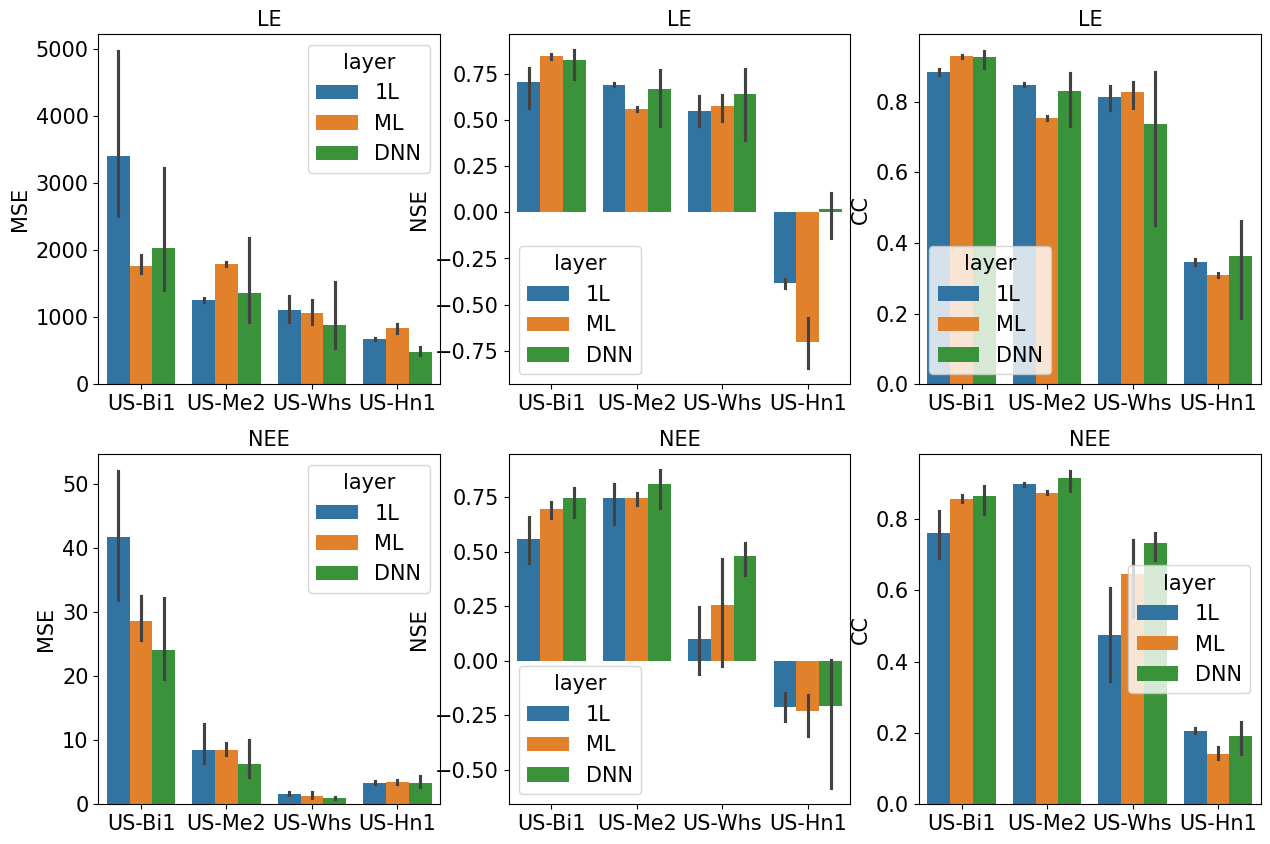

In [36]:
train_or_test, model = "test", ["Hybrid", "DNN"]
fig, axes = plt.subplots(len(outputs), len(metrics), figsize=(15, 10))
for i, varn in enumerate(outputs):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        df_metrics_sub = filter_metric(
            df_metrics, model=model, varn=varn, train_or_test=train_or_test
        )
        sns.barplot(df_metrics_sub, ax=ax, x="site", y=metric, hue="layer", legend=True)
        ax.set(xlabel="", ylabel=metric.upper(), title=varn)

# Pareto Front curve (multi-objective optimization)

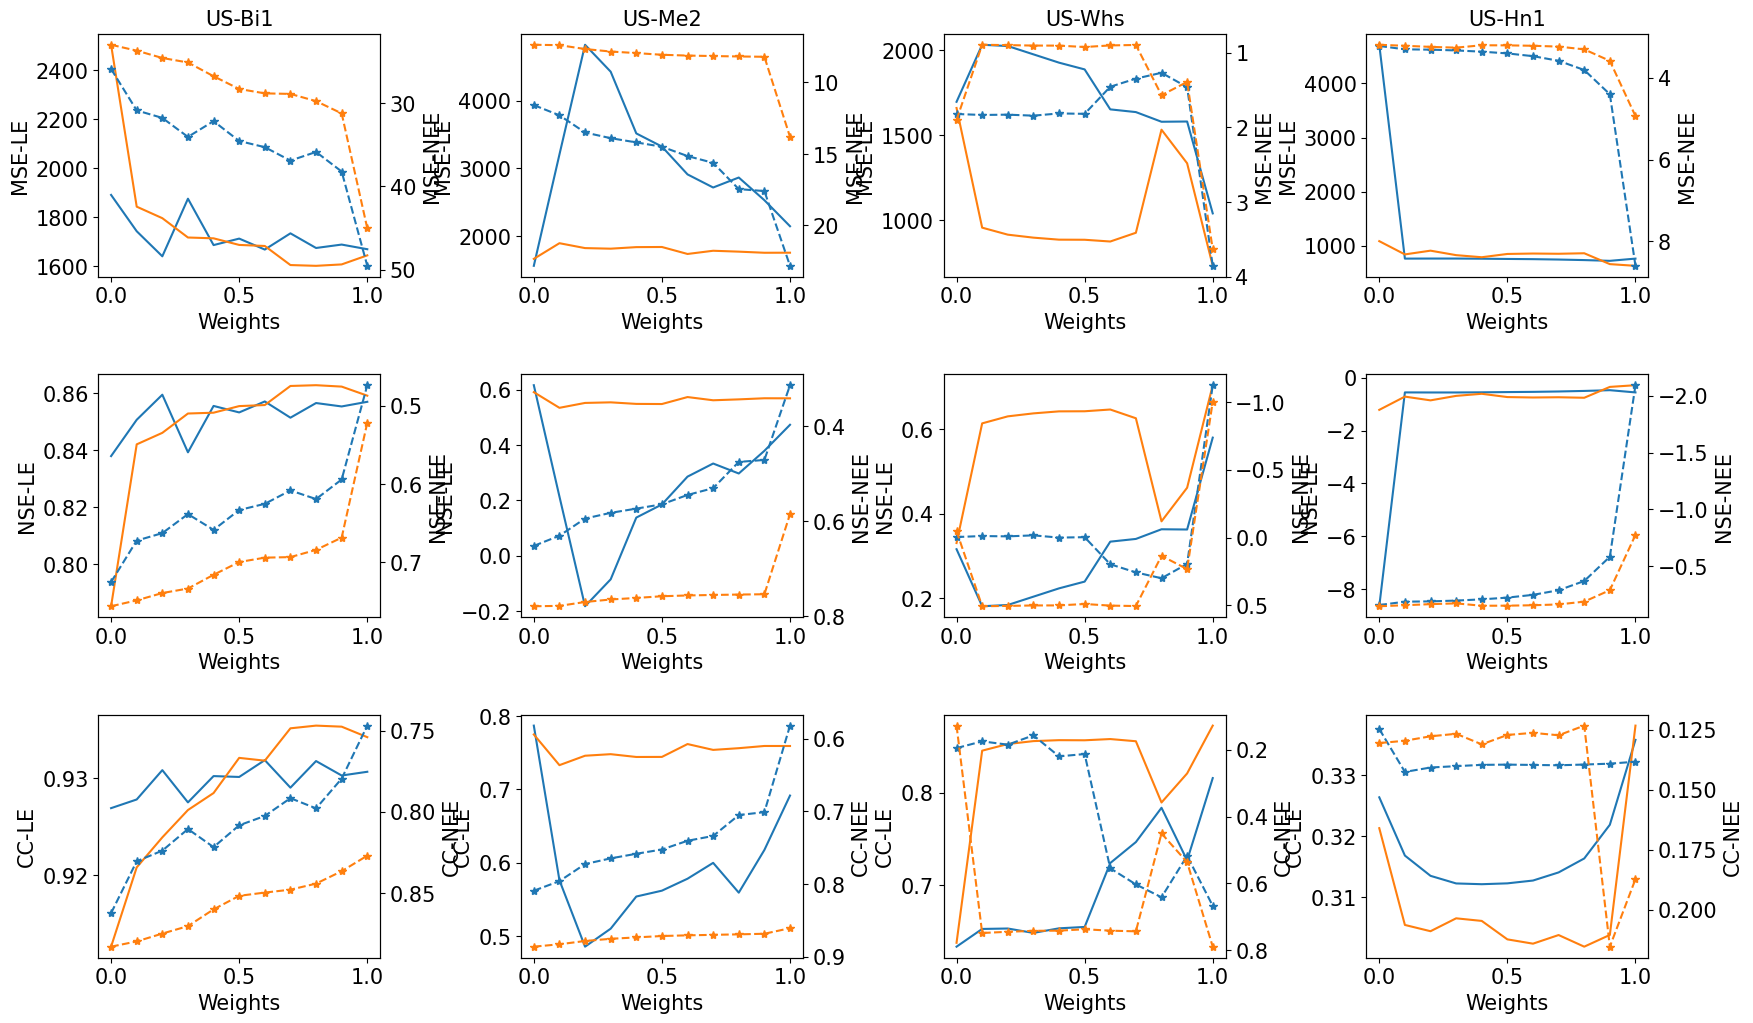

In [37]:
train_or_test, layer = "test", "ML"
fig, axes = plt.subplots(len(metrics), len(sites), figsize=(20, 12))
for j, site in enumerate(sites):
    for i, metric in enumerate(metrics):
        ax = axes[i, j]
        # Process-based
        le_m = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="PB",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        nee_m = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="PB",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        # Hybrid
        le_hm = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="Hybrid",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        nee_hm = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="Hybrid",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        # DNN
        le_dm = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="DNN",
            layer="DNN",
            train_or_test=train_or_test,
        )[metric]
        nee_dm = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="DNN",
            layer="DNN",
            train_or_test=train_or_test,
        )[metric]
        
        ax.plot(le_weight, le_m, "-", label=f"PB-{layer}")
        ax.plot(le_weight, le_hm, "-", label=f"Hybrid-{layer}")
        # ax.plot(le_weight, le_dm, "-", label=f"DNN-{layer}")
        # ax.legend()
        ax.set(title=site if i == 0 else "", ylabel=f"{metric.upper()}-LE", xlabel='Weights')
        
        ax2 = ax.twinx()
        ax2.invert_yaxis()
        ax2.plot(le_weight, nee_m, "*--", label=f"PB-{layer}")
        ax2.plot(le_weight, nee_hm, "*--", label=f"Hybrid-{layer}")
        # ax2.plot(le_weight, nee_dm, "*--", label=f"DNN-{layer}")
        # ax2.legend()
        ax2.set(ylabel=f"{metric.upper()}-NEE")

        # ax.set(
        #     xlabel=f"{metric.upper()}-LE",
        #     ylabel=f"{metric.upper()}-NEE",
        #     title=site if i == 0 else "",
        # )
plt.subplots_adjust(wspace=0.5, hspace=0.4)


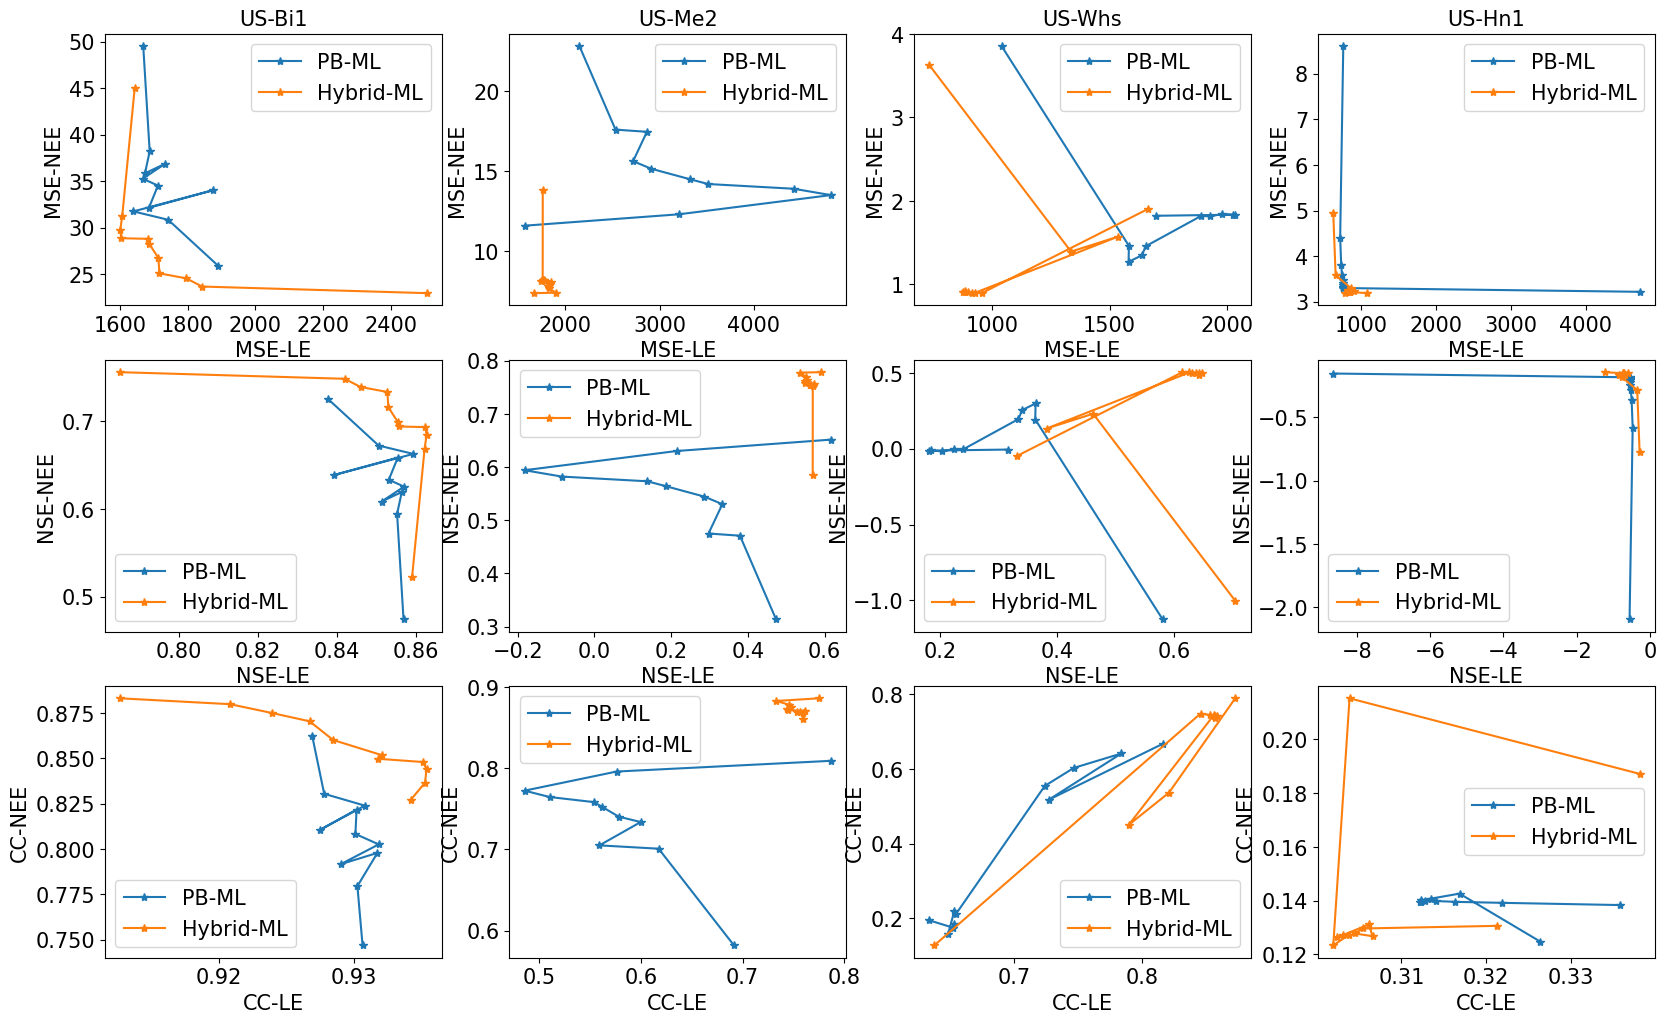

In [38]:
train_or_test, layer = "test", "ML"
fig, axes = plt.subplots(len(metrics), len(sites), figsize=(20, 12))
for j, site in enumerate(sites):
    for i, metric in enumerate(metrics):
        ax = axes[i, j]
        # Process-based
        le_m = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="PB",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        nee_m = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="PB",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        # ax.scatter(le_m, nee_m, label='PB-1L')
        ax.plot(le_m, nee_m, "*-", label=f"PB-{layer}")

        # Hybrid
        le_m = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="Hybrid",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        nee_m = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="Hybrid",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        # ax.scatter(le_m, nee_m, label='Hybrid-1L')
        ax.plot(le_m, nee_m, "*-", label=f"Hybrid-{layer}")

        # DNN
        le_m = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="DNN",
            layer="DNN",
            train_or_test=train_or_test,
        )[metric]
        nee_m = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="DNN",
            layer="DNN",
            train_or_test=train_or_test,
        )[metric]
        # ax.scatter(le_m, nee_m, label='DNN')
        ax.legend()

        ax.set(
            xlabel=f"{metric.upper()}-LE",
            ylabel=f"{metric.upper()}-NEE",
            title=site if i == 0 else "",
        )

# Time series plot

## Diurnal signal

In [12]:
def convert_to_24hr(df):
    df = df.resample("30T").mean()
    df["Time_of_Day"] = df.index.time
    # Pivot to get the average value for each 30-minute interval across 24-hour periods
    return df.groupby("Time_of_Day").mean()

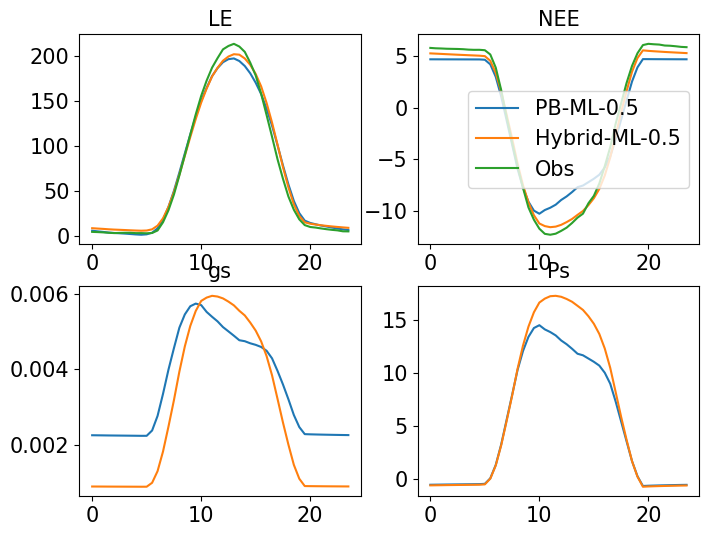

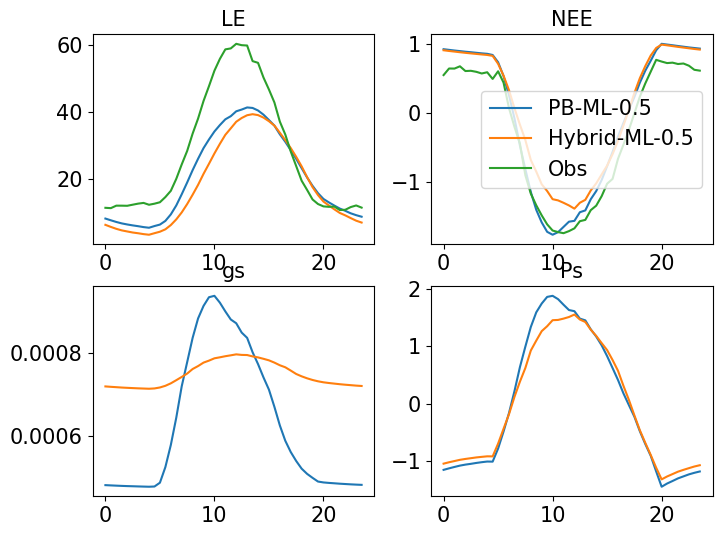

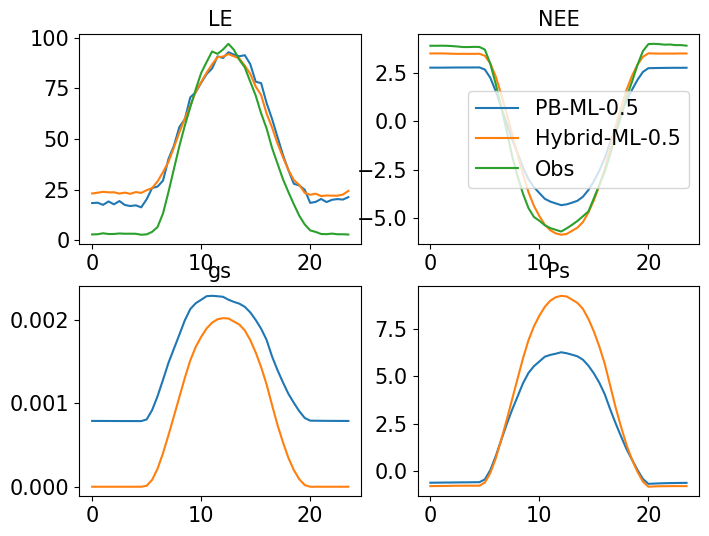

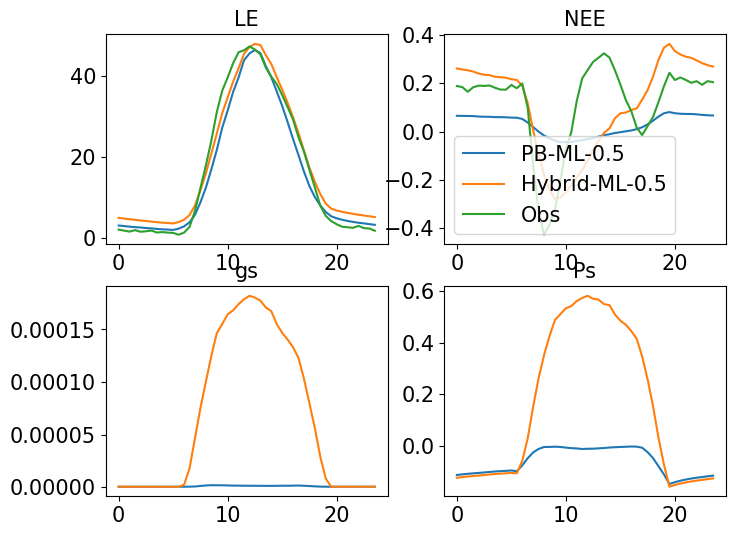

In [55]:
train_or_test, layer, weight = "train", "ML", "0.5"
for site in sites:
    df = df_simulations_set[f"{site}-{train_or_test}"]
    pb = convert_to_24hr(df[f"PB-{layer}-{weight}"])
    hybrid = convert_to_24hr(df[f"Hybrid-{layer}-{weight}"])
    pb.index = pb.index.map(lambda x: x.hour+x.minute/60.)
    hybrid.index = hybrid.index.map(lambda x: x.hour+x.minute/60.)
    # dnn = convert_to_24hr(df[f'DNN_LE-GPP-{weight}'])

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    axes = axes.flatten()
    ax = axes[0]
    pb["LE"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["LE"].plot(ax=ax, label=f"Hybrid-{layer}-{weight}")
    pb["LE-obs"].plot(ax=ax, label="Obs")
    ax.set(title="LE", xlabel='')

    ax = axes[1]
    pb["NEE"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["NEE"].plot(ax=ax, label=f"Hybrid-{layer}-{weight}")
    pb["NEE-obs"].plot(ax=ax, label="Obs")
    ax.set(title="NEE", xlabel='')
    ax.legend()

    ax = axes[2]
    pb["gs"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["gs"].plot(ax=ax, label=f"Hybrid-{layer}-{weight}")
    ax.set(title="gs", xlabel='')

    ax = axes[3]
    pb["Ps"].plot(ax=ax, label=f"PB-{layer}-{weight}")
    hybrid["Ps"].plot(ax=ax, label=f"Hybrid-{layer}")
    ax.set(title="Ps", xlabel='')


## Full time series

In [17]:
def convert_to_24hr(df):
    df = df.resample("30T").mean()
    df["Time_of_Day"] = df.index.time
    # Pivot to get the average value for each 30-minute interval across 24-hour periods
    return df.groupby("Time_of_Day").mean()

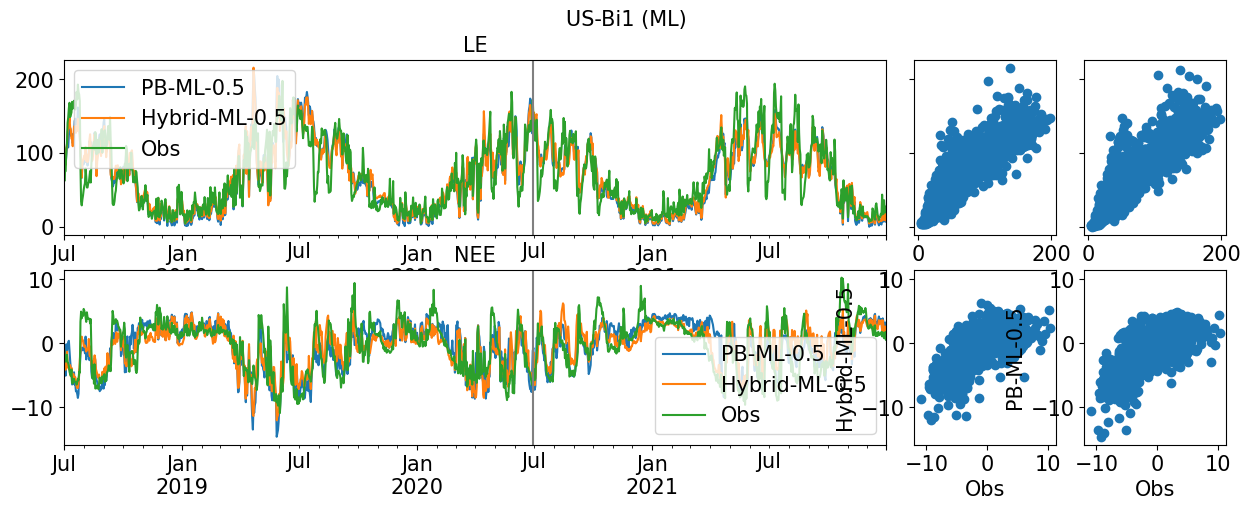

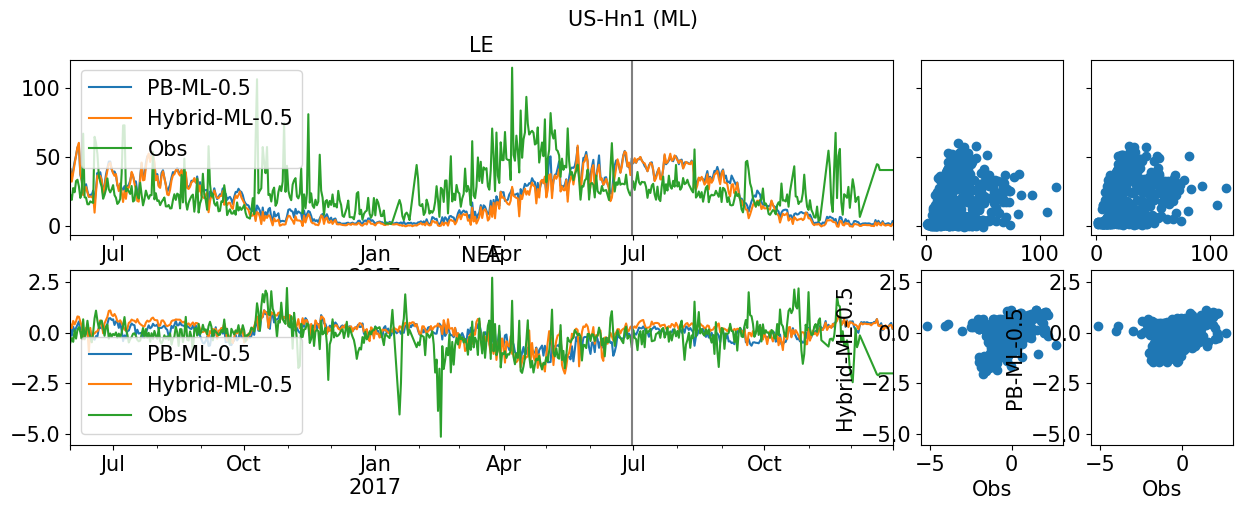

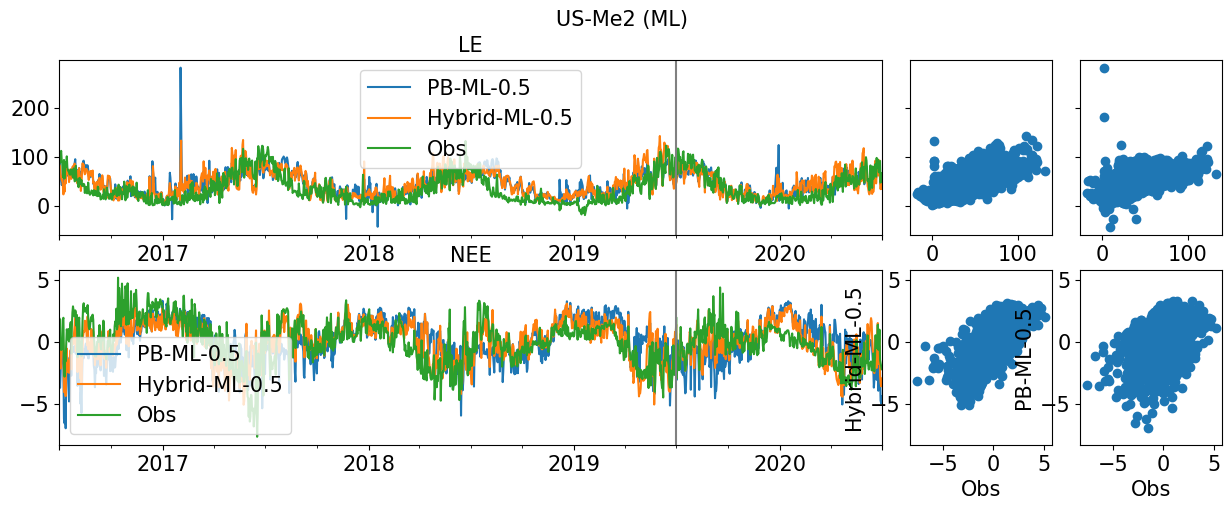

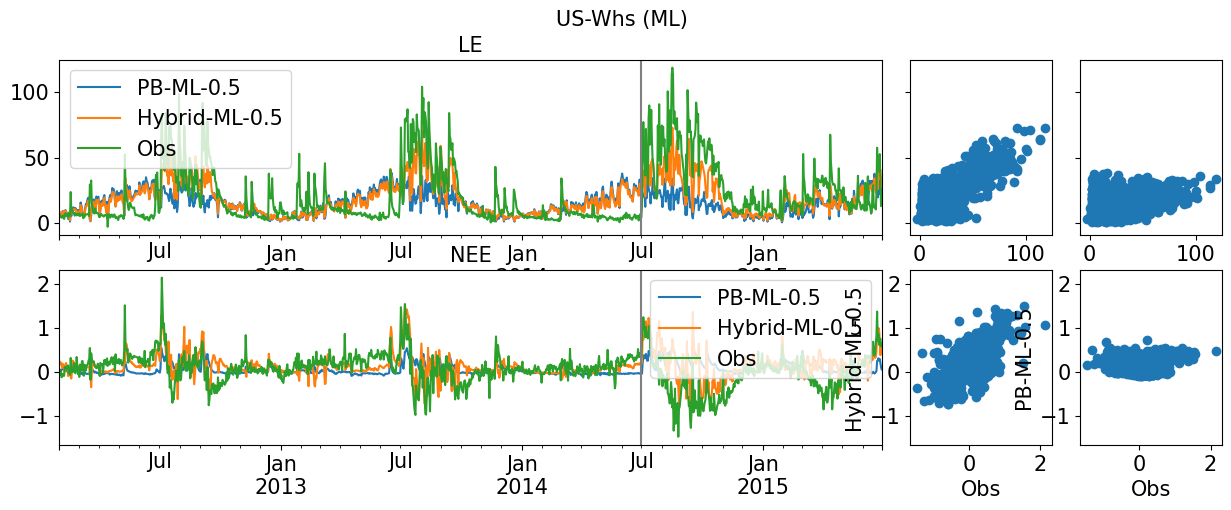

In [60]:
weight = "0.5"
for site,layer in itertools.product(sites, ['ML']):
    # Train data
    train_pb = (
        df_simulations_set[f"{site}-train"][f"PB-{layer}-{weight}"].resample("D").mean()
    )
    train_hybrid = (
        df_simulations_set[f"{site}-train"][f"Hybrid-{layer}-{weight}"]
        .resample("D")
        .mean()
    )
    # train_dnn = df_simulations_set[f"{site}-train"][f'DNN_LE-GPP-{weight}']

    # test data
    test_pb = (
        df_simulations_set[f"{site}-test"][f"PB-{layer}-{weight}"].resample("D").mean()
    )
    test_hybrid = (
        df_simulations_set[f"{site}-test"][f"Hybrid-{layer}-{weight}"]
        .resample("D")
        .mean()
    )
    # test_dnn = df_simulations_set[f"{site}-test"][f'DNN_LE-GPP-{weight}']
    train_test_split = train_hybrid.index[-1]

    pb = pd.concat([train_pb, test_pb])
    hybrid = pd.concat([train_hybrid, test_hybrid])

    # fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(2, 7, figure=fig)
    ax1 = fig.add_subplot(gs[0,:-2])
    pb["LE"].plot(ax=ax1, label=f"PB-{layer}-{weight}")
    hybrid["LE"].plot(ax=ax1, label=f"Hybrid-{layer}-{weight}")
    pb["LE-obs"].plot(ax=ax1, label="Obs")
    ax1.axvline(x=train_test_split, color="grey")
    ax1.legend()
    ax1.set(title="LE")
    
    ax = fig.add_subplot(gs[0,-2], sharey=ax1)
    ax.scatter(pb["LE-obs"], hybrid["LE"])
    ax.set(xlabel='Obs', ylabel=f"Hybrid-{layer}-{weight}")
    
    ax = fig.add_subplot(gs[0,-1], sharey=ax1)
    ax.scatter(pb["LE-obs"], pb["LE"])
    ax.set(xlabel='Obs', ylabel=f"PB-{layer}-{weight}")

    ax2 = fig.add_subplot(gs[1,:-2])
    pb["NEE"].plot(ax=ax2, label=f"PB-{layer}-{weight}")
    hybrid["NEE"].plot(ax=ax2, label=f"Hybrid-{layer}-{weight}")
    pb["NEE-obs"].plot(ax=ax2, label="Obs")
    ax2.axvline(x=train_test_split, color="grey")
    ax2.legend()
    ax2.set(title="NEE")
    
    ax = fig.add_subplot(gs[1,-2], sharey=ax2)
    ax.scatter(pb["NEE-obs"], hybrid["NEE"])
    ax.set(xlabel='Obs', ylabel=f"Hybrid-{layer}-{weight}")
    
    ax = fig.add_subplot(gs[1,-1], sharey=ax2)
    ax.scatter(pb["NEE-obs"], pb["NEE"])
    ax.set(xlabel='Obs', ylabel=f"PB-{layer}-{weight}")

    fig.suptitle(f'{site} ({layer})');


In [20]:
# filter_metric(
#     df_metrics, site='US-Whs', model=['PB', 'Hybrid'], layer=['ML', '1L'],
#     weight=None, varn='LE', train_or_test='test',
# )


In [21]:
# filter_metric(
#     df_metrics, site='US-Whs', model=['PB', 'Hybrid'], layer=['ML', '1L'],
#     weight=None, varn='NEE', train_or_test='test',
# )
